# Exploratory data analysis of Amsterdam's Airbnb data

## Introduction



I was looking for an interesting dataset to explore and I came across the [InsideAirbnb](http://insideairbnb.com) dataset, which contains summary information and metrics for Airbnb listings in various cities. Here I decided to explore Airbnb listings in Amsterdam. 

I did not have any specific questions in mind, I just wanted to see which insights I could gain from the data (also, it wouldn't hurt if this analysis could help me find a good accommodation deal :))

This analysis consists of the following parts:
- First look at the dataset and data cleaning
- Exploring prices
- Looking at room types
- Looking at minimum nights requirement
- Which host has the most listings?

The data was compiled by [InsideAirbnb](http://insideairbnb.com). The dataset contains quarterly data for the last year.

[Source](http://insideairbnb.com/get-the-data.html) and [license](https://creativecommons.org/licenses/by/4.0/) of dataset. 

## First look at the dataset and data cleaning

After displaying the first few rows of the dataset, it seemed like the  `neighbourhood_group` column had a lot of null values, which was confirmed by further exploration, where we could see that the `neighbourhood_group` only contains NaN values, so I dropped it. So either the dataset is incomplete, or Amsterdam is not administratively divided into neighborhood groups, but this variable is important for larger cities.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopy.distance
import urllib
import plotly.express as px
import random

Amsterdam = pd.read_csv("listings_Amsterdam.csv")
Amsterdam.head()
print(Amsterdam.shape)
print(Amsterdam.isnull().sum())

(6809, 18)
id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               6809
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                        648
reviews_per_month                  648
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                            138
dtype: int64


In [2]:
Amsterdam.drop(columns = ["neighbourhood_group"], inplace = True)

## Exploring prices

Next, I wanted to see which parts of Amsterdam are cheaper or more expensive by examining the price per night of accommodation in the dataset.

After examining the lowest and highest price values, I decided to remove some outliers (e.g., we see listings that ask for 0 or 70 000 per night) by removing rows with price per night greater than is equal to 0 or larger than  1000 EUR. 

In [4]:
print("10 lowest unique prices:", np.sort(Amsterdam["price"].unique())[:10])
print("10 largest unique prices:", np.sort(Amsterdam["price"].unique())[-10:])

10 lowest unique prices: [ 0 20 24 30 31 32 34 35 36 37]
10 largest unique prices: [ 1779  1920  2000  2350  2656  2688  7900  9198 26696 71536]


In [20]:
Amsterdam = Amsterdam[Amsterdam["price"] != 0]
Amsterdam = Amsterdam[Amsterdam["price"] < 1000]
print(Amsterdam.shape)

(6769, 17)


The histogram plot shows that the price per night is right skewed, and most listings are within the range of 150 to 220 euros per night. This plot would be much less informative without removing the outliers in the previous step. 

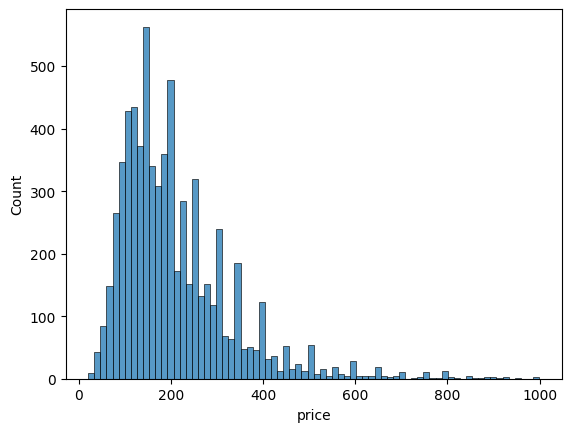

In [22]:
price_hist = sns.histplot(data = Amsterdam, x = "price")

Next, I wanted to see if prices differ between neighborhoods. The boxplot of prices per neighborhood shows that Zuid (Dutch for south), Centrum, De Pijp, and West are the most expensive by the median price. However, we can find reasonably cheap or expensive accommodations in each neighborhood. But, of course, the quality of the accommodation we get for the price might be different. 

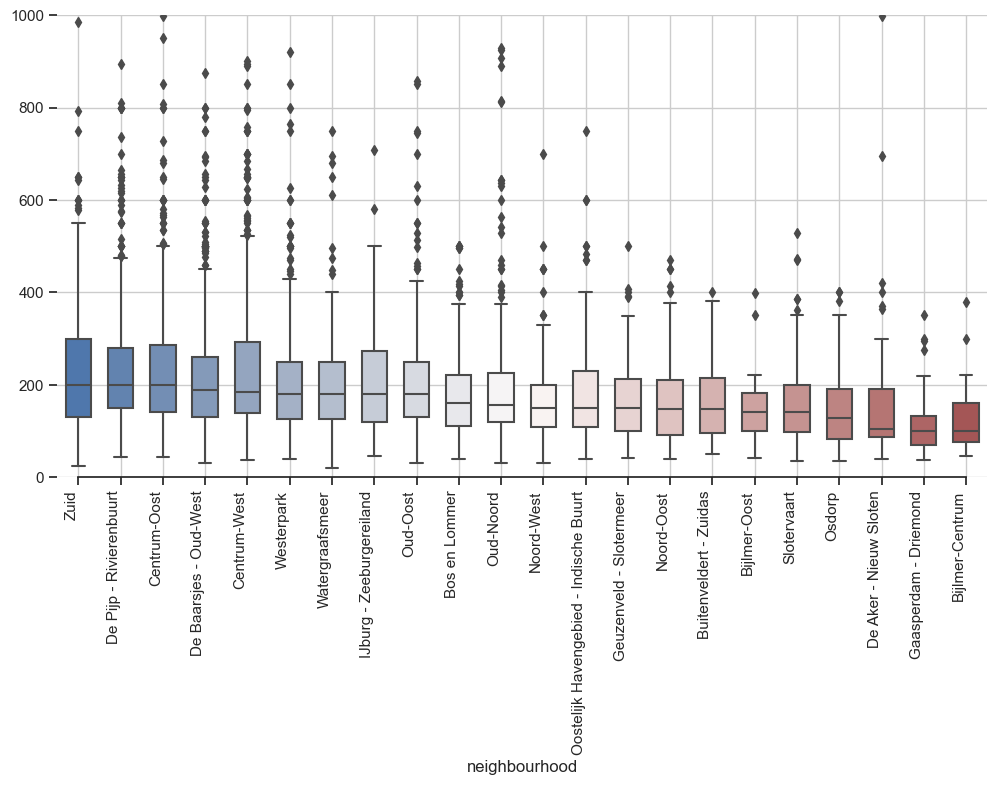

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="ticks")
ax.set(ylim=(0, 1000))

med = Amsterdam.groupby("neighbourhood", as_index = False)[["neighbourhood", "price"]].median()
med = med.sort_values(by = "price", ascending = False)
med_list = med["neighbourhood"].tolist()

sns.boxplot(data = Amsterdam, x = "neighbourhood", y = "price", 
            width=.6, palette="vlag", order = med_list)

ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

Next, I divided prices into five price ranges and plotted them on the map of the city.  There is no apparent relationship visible on the map, which confirms what we saw in the boxplot that cheap and expensive accommodations could be found all over the city. 

In [40]:
Amsterdam["discrete_price"] = pd.qcut(Amsterdam["price"], 5)

fig = px.scatter_mapbox(Amsterdam, 
                        lat='latitude',
                        lon='longitude',
                        color='discrete_price',
                        hover_name="name",
                        center={'lat':52.3676,
                                'lon':4.9041},
                        zoom=12)

fig.update_layout(mapbox_style='open-street-map')
fig.show()

Even when zoomed in, the map visualization did not provide enough valuable insights, so I tried a different approach.

I plotted latitude and longitude vs. price, and the graphs show that there is indeed a spatial relationship between prices. We can see that prices peak at around 52.37 latitude and 4.88 longitude, which I assume is Amsterdam's (price) center. The prices get higher around this point.

I created a new variable distance from the center, using a function from `geopy`, which calculates a geographic distance between two points based on their latitude and longitude coordinates. I plotted this on the map to show how far each accommodation is from my estimated center. 

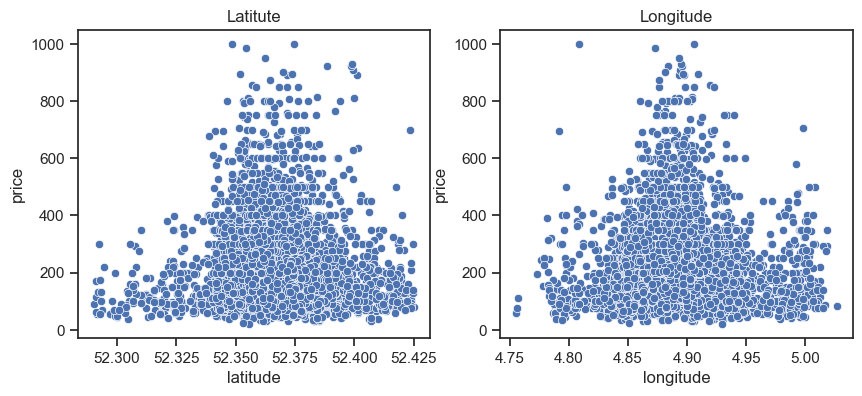

In [47]:
fig2, (ax2, ax3) = plt.subplots(1,2, figsize=(10,4))
ax2.set_title('Latitute')
sns.scatterplot(data = Amsterdam, x = "latitude", y = "price", ax=ax2)
ax3.set_title('Longitude')
sns.scatterplot(data = Amsterdam, x = "longitude", y = "price",ax=ax3)

fig2.show()


In [49]:
distance = []

for i in range(Amsterdam.shape[0]):
    coords_1 = (52.37, 4.88)
    coords_2 = (Amsterdam["latitude"].iloc[i], Amsterdam["longitude"].iloc[i])
    distance.append(geopy.distance.geodesic(coords_1, coords_2).km)
    
Amsterdam["distance_from_center"] = distance

In [57]:

fig = px.scatter_mapbox(Amsterdam, 
                        lat='latitude',
                        lon='longitude',
                        color='distance_from_center',
                        hover_name="name",
                        center={'lat':52.37,
                                'lon':4.88},
                        zoom=10,
                        color_continuous_scale="inferno_r")

fig.update_layout(mapbox_style='open-street-map')
fig.show()

In the next step, I plotted the polynomial regression between price and distance from the center. The plot shows that the price per night is approximately 50 eur higher in the center than 6 km away from the center. 

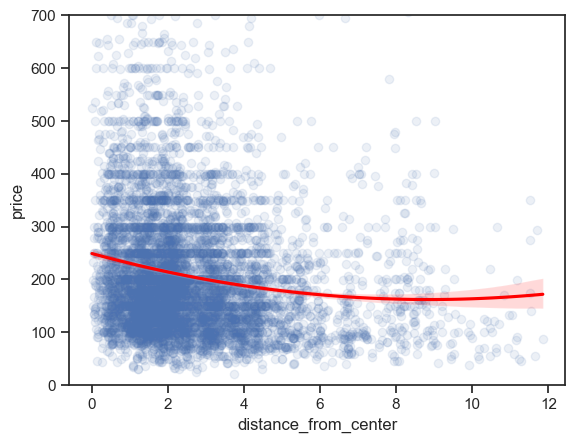

In [59]:
price_distance = sns.regplot(data = Amsterdam, x = "distance_from_center", y = "price", fit_reg= True, order=2, scatter_kws={'alpha':0.1}, line_kws={'color':"red"})
# price_distance.set_yscale("log")
price_distance.set_ylim((0,700))
plt.show()

## Looking at room types

In the next part of this exploratory analysis, I looked at room types, which might also partially explain the price differences between neighborhoods. 

The bat chart of room types shows that the vast majority of accommodation listings are entire home/appartment, and the second most common category is a private room.

The entire home/apartment is the most popular category in all the neighborhoods, except for De Aker - Nieuw-Sloten, where most listings are private rooms.

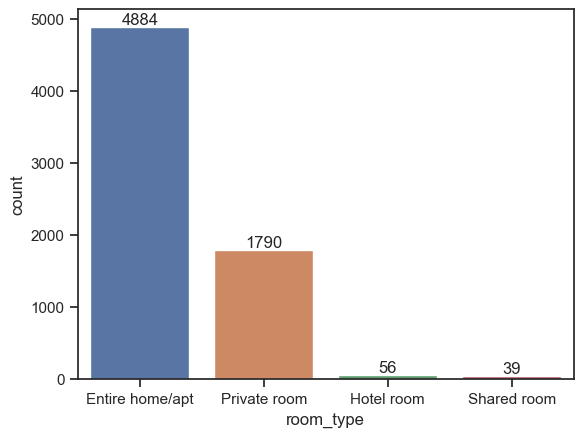

In [60]:
all_room_types = sns.countplot(Amsterdam, x = "room_type")
all_room_types.bar_label(all_room_types.containers[0])
plt.show()

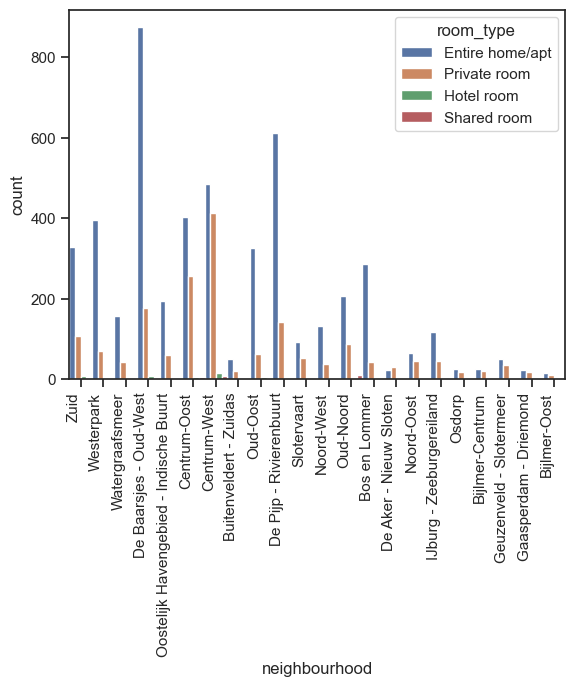

In [61]:
all_room_types = sns.countplot(Amsterdam, x = "neighbourhood", width = 1, hue = "room_type")
all_room_types.set_xticklabels(all_room_types.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

The scatterplot shows that most of the hotels are located within 6 km from the center, but there are also a few hotels in the southeast, which is a relatively remote part of the city, but it is connected by metro. 

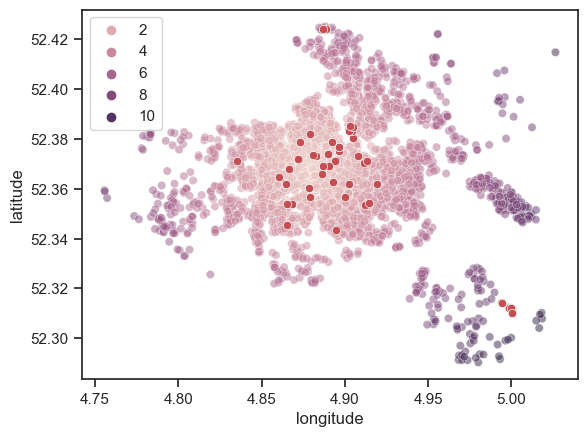

In [64]:
sns.scatterplot(data = Amsterdam, 
                x = "longitude", 
                y = "latitude", 
                hue = "distance_from_center", 
                alpha = 0.5)
                
map_neighbourhood = sns.scatterplot(data = Amsterdam.query("room_type == 'Hotel room'"), 
                                    x = "longitude", 
                                    y = "latitude",color= "r")

plt.show()

## Looking at minimum nights requirement

In the next part of the analysis, I looked at the minimum night requirement. A brief examination of unique values shows that there are some outliers with more than 300 minimum nights required. I did not notice any common pattern that could explain these outliers.

In [66]:
min_nights_options = np.sort(Amsterdam["minimum_nights"].unique())
print(min_nights_options)

#checking listings with a min nights > 300

Amsterdam[Amsterdam["minimum_nights"] > 300]

[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   18   20   21   24   25   26   27   28   29   30   31   40
   45   55   60   75   90   93  100  120  150  180  183  300  500  800
 1000 1001]


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,discrete_price,distance_from_center
964,7394725,Light apartment - quiet neighbourh.,1930105,Roel,Bos en Lommer,52.37928,4.85735,Entire home/apt,131,800,41,2021-11-09,0.47,1,352,0,0363 ED9D D582 73F0 0D4D,"(114.0, 153.0]",1.856271
2063,18471773,★ DUPLEX APARTMENT ★ AMSTERDAM ★ NDSM WARF ★,46691672,Eva & Kobe,Oud-Noord,52.39974,4.90415,Entire home/apt,127,1000,19,2022-04-24,0.28,9,0,2,0363 5F75 487F 8C50 AF40,"(114.0, 153.0]",3.695306
2157,19343174,Modern and Luxurious apt in the centre of A'dam,50435166,Kees,De Pijp - Rivierenbuurt,52.34836,4.90842,Entire home/apt,220,500,36,2022-05-16,0.55,2,89,3,0363 437A 46CA C3B3 DCF3,"(200.0, 286.0]",3.089836
2209,18816109,Nice room,21681343,Raffaele,De Pijp - Rivierenbuurt,52.35183,4.89873,Private room,121,1001,24,2018-11-25,0.38,2,89,0,0363 80E2 0920 0E13 6E13,"(114.0, 153.0]",2.390812
2582,24193584,★★★ THE ULTIMATE AMSTERDAM EXPERIENCE ★ A/C ★★★,46691672,Eva & Kobe,Centrum-Oost,52.36231,4.90647,Entire home/apt,500,1000,29,2022-09-12,0.54,9,0,8,0363 7A78 2957 7BF1 6AE7,"(286.0, 999.0]",1.995787
3844,38903493,New and modern apartment near the Vondelpark,179227487,Annemarie,Zuid,52.35159,4.85466,Entire home/apt,175,1000,15,2022-10-18,0.44,1,12,8,0363 6F19 5020 DCE4 AD4C,"(153.0, 200.0]",2.678921
5838,664383793095034535,★NEW: CANAL VIEWS ★ CREATIVE TOUCH ★ JORDAAN ★,467794608,Johanna,Centrum-West,52.37516,4.88068,Entire home/apt,429,1000,8,2022-10-23,1.88,1,6,8,0363B7015656D87F8AEB,"(286.0, 999.0]",0.576041


Using a bar chart, I compared listings with a minimum stay of at least 7 nights to listings with a minimum stay of fewer than 7 nights. We see that most listings across all room types do not require a minimum stay of more than 7 days. 

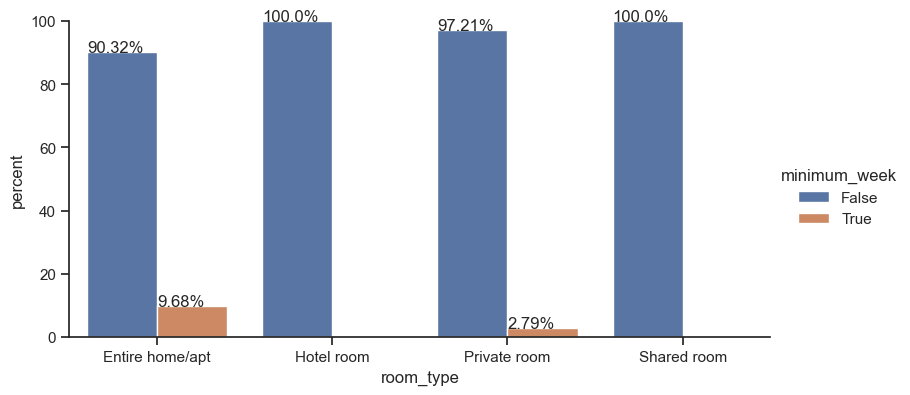

In [67]:
Amsterdam["minimum_week"] = Amsterdam["minimum_nights"] >= 7


Amsterdam1 = Amsterdam.groupby("room_type")["minimum_week"].value_counts(normalize=True)
Amsterdam1 = Amsterdam1.mul(100)
Amsterdam1 = Amsterdam1.rename('percent').reset_index()

percentage_min_nights = sns.catplot(x="room_type",y='percent',hue="minimum_week",kind='bar',data=Amsterdam1, height = 4, aspect = 2)
percentage_min_nights.ax.set_ylim(0,100)


for p in percentage_min_nights.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    percentage_min_nights.ax.text(txt_x,txt_y,txt)


plt.show()

 There is a slight positive correlation between minimum_nights and price, which is surprising because I expect longer stays to be cheaper per night. I used Spearman's rank correlation, which is robust to outliers, therefore this effect cannot be caused by a few extreme values.

In [69]:
Amsterdam[["minimum_nights", "price"]].corr(method = "spearman")


,minimum_nights,price
minimum_nights,1.000000,0.103351
price,0.103351,1.000000


## Conclusion

This analysis showed some nice relationships in the data, which gave me ideas for other explorations. In the future, I would like to compare Airbnb listings of Amsterdam to those of other European capitals and to see how the Airbnb market changed over time. Unfortunately, the data in the dataset is always a couple of months old, so it does not guarantee that I would find a good accommodation deal 